<a href="https://colab.research.google.com/github/MichaelGajhede/superdex_200_calibration/blob/main/superdex_200_calib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SEC Calibration: $\log(MW)$ vs. $k_{avg}$

In size exclusion chromatography (SEC), the elution behavior of molecules is related to their size in solution. While elution volume ($V_e$) is the most common parameter, $k_{avg}$ can also be used.

### 1. Understanding $k_{avg}$

The parameter $k_{avg}$ represents the fraction of the stationary phase accessible to a solute molecule:

$\
k_{avg} = \frac{V_e - V_o}{V_t - V_o}
\$

Where:

* $V_e$ = Elution volume
* $V_o$ = Void volume
* $V_t$ = Total column volume

### 2. Calibration Procedure

1.  **Run Standards:** Inject standards with known molecular weights ($M$).
2.  **Measure $V_e$:** Determine the elution volume for each standard.
3.  **Determine $V_o$ and $V_t$:**
    * $V_o$: Elution volume of a very large molecule.
    * $V_t$: Column volume (from dimensions or manufacturer).
4.  **Calculate $k_{avg}$:** Calculate $k_{avg}$ for each standard.
5.  **Plot Calibration Curve:** Plot $\log(M)$ vs. $k_{avg}$.
6.  **Fit the Data:** Fit the data to a function (e.g., polynomial):

    $
    \log(M) = a_0 + a_1 k_{avg} + a_2 k_{avg}^2 + ... + a_n k_{avg}^n
    $

    Where $a_i$ are constants.

### 3. Using the Calibration Curve

For an unknown sample:

1.  Measure $V_e$.
2.  Calculate $k_{avg}$.
3.  Determine $M_{unknown}$:

    $\
    M_{unknown} = 10^{(a_0 + a_1 k_{avg,unknown} + a_2 k_{avg,unknown}^2 + ... + a_n k_{avg,unknown}^n)}
    \$

### 4. Advantages of $k_{avg}$

* Normalized parameter.
* Direct measure of stationary phase accessibility.

### 5. Considerations

* Same precautions as with $V_e$ calibration.
* Accurate $V_o$ and $V_t$ are crucial.
* Empirical relationship, requires a suitable fit.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data extracted from the calibration figure in the superdex 10/300 gl manual using gemini
data = {
    'Sample': ['1. Thyroglobulin (Mr 669 000) 3 mg/mL',
               '2. Ferritin (Mr 440 000) 0.3 mg/mL',
               '3. Aldolase (Mr 158 000) 3 mg/mL',
               '4. Conalbumin (Mr 75 000) 3 mg/mL',
               '5. Ovalbumin (Mr 44 000) 3 mg/mL',
               '6. Carbonic anhydrase (Mr 29 000) 3 mg/mL',
               '7. Ribonuclease A (Mr 13 700) 3 mg/mL'],
    'Elution Volume (mL)': [8.5, 9.5, 11.5, 13.5, 14.5, 16.5, 17.5]
}

# Create the DataFrame
df_standards = pd.DataFrame(data)

# Extract the number from within the parentheses
df_standards['MW (Mr)'] = df_standards['Sample'].str.extract(r'Mr\s(\d+)')

# Convert the extracted 'MW (Mr)' column to numeric
df_standards['MW (Mr)'] = pd.to_numeric(df_standards['MW (Mr)'])


# Print the resulting DataFrame
print(df_standards)


                                      Sample  Elution Volume (mL)  MW (Mr)
0      1. Thyroglobulin (Mr 669 000) 3 mg/mL                  8.5      669
1         2. Ferritin (Mr 440 000) 0.3 mg/mL                  9.5      440
2           3. Aldolase (Mr 158 000) 3 mg/mL                 11.5      158
3          4. Conalbumin (Mr 75 000) 3 mg/mL                 13.5       75
4           5. Ovalbumin (Mr 44 000) 3 mg/mL                 14.5       44
5  6. Carbonic anhydrase (Mr 29 000) 3 mg/mL                 16.5       29
6      7. Ribonuclease A (Mr 13 700) 3 mg/mL                 17.5       13


Slope and intercept: [-0.14724835  0.98355918]


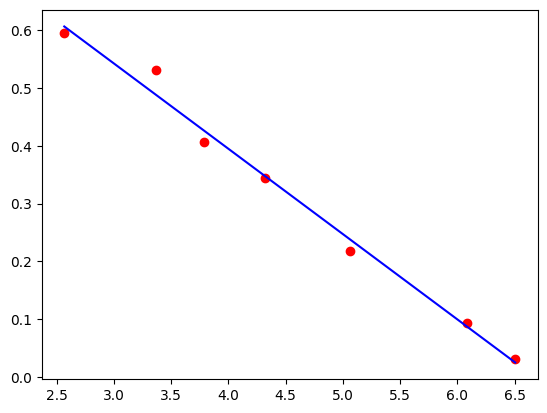

,Sample,Elution Volume (mL),MW (Mr),K average
0,1. Thyroglobulin (Mr 669 000) 3 mg/mL,8.5,669,0.03125
1,2. Ferritin (Mr 440 000) 0.3 mg/mL,9.5,440,0.09375
2,3. Aldolase (Mr 158 000) 3 mg/mL,11.5,158,0.21875
3,4. Conalbumin (Mr 75 000) 3 mg/mL,13.5,75,0.34375
4,5. Ovalbumin (Mr 44 000) 3 mg/mL,14.5,44,0.40625
5,6. Carbonic anhydrase (Mr 29 000) 3 mg/mL,16.5,29,0.53125
6,7. Ribonuclease A (Mr 13 700) 3 mg/mL,17.5,13,0.59375


In [5]:
# least squares fit of Kav=a*lnMW+b where Kav=(Vret-Vo)/(Vcol-Vo) determine intercept and slope
import numpy as np
from scipy.sparse import rand
from scipy.optimize import curve_fit

V0 = 8 #Superdex 200 10/300 increase void volume
Vcol = 24 #Superdex 200 10/300 increase total volume
Kavs =[]
for i in df_standards['Elution Volume (mL)']:
    Kav = (i-V0)/(Vcol-V0)
    Kavs.append(Kav)

df_standards['K average'] = Kavs



x = np.log(df_standards['MW (Mr)'].to_numpy())
y = df_standards['K average'].to_numpy()

def func(x, a, b):
    y = a*x + b
    return y

alpha_MW = curve_fit(func, xdata = x, ydata = y)[0] # returns slope and intercept tupple
print('Slope and intercept:', alpha_MW)

plt.plot(x, y, 'ro', label='K Average observed')
plt.plot(x, func(x, *alpha_MW), 'b-', label='K average fit')
plt.show()

df_standards


In [9]:
# calculate MW of sample with known elution time

sample_elution_ml = 15

Kav = (sample_elution_ml-V0)/(Vcol-V0)
MW_sample = int(np.exp((Kav- alpha_MW[1])/alpha_MW[0]))
print('Sample eluting at:' , sample_elution_ml, 'ml has a molecular weight of:',  MW_sample, 'kDa')


Sample eluting at: 15 ml has a molecular weight of: 40 kDa
